In [13]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    LSTM, Bidirectional, TimeDistributed, Input,
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Paths
VIOLENCE_PATH = "data/Violence"
NONVIOLENCE_PATH = "data/NonViolence"

In [15]:
# Configs
SEQUENCE_LENGTH = 16
IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50

### Load 

In [16]:
def extract_frames(video_path, sequence_length, img_height, img_width, channels):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, sequence_length, dtype=int)

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (img_width, img_height))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
        else:
            frames.append(frames[-1] if frames else np.zeros((img_height, img_width, channels)))

    cap.release()
    return np.array(frames)


def load_dataset(violence_path, nonviolence_path, sequence_length, img_height, img_width, channels):
    sequences, labels = [], []

    for label, path in [(1, violence_path), (0, nonviolence_path)]:
        if os.path.exists(path):
            video_files = [f for f in os.listdir(path) if f.endswith(('.mp4', '.avi', '.mov'))]
            for video in tqdm(video_files, desc=f"Loading {'Violence' if label else 'Non-Violence'}"):
                video_path = os.path.join(path, video)
                frames = extract_frames(video_path, sequence_length, img_height, img_width, channels)
                if frames is not None and len(frames) == sequence_length:
                    sequences.append(frames)
                    labels.append(label)

    if not sequences:
        raise ValueError("No videos found. Please check dataset paths.")

    return np.array(sequences), np.array(labels)


In [ ]:
class ViolenceDetectionModel:
    def __init__(self, sequence_length=16, img_height=64, img_width=64, channels=3):
        self.sequence_length = sequence_length
        self.img_height = img_height
        self.img_width = img_width
        self.channels = channels
        self.model = None
        self.history = None

    def create_cnn(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(self.img_height, self.img_width, self.channels)),
            BatchNormalization(),
            MaxPooling2D((2, 2)),

            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),

            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),

            Conv2D(256, (3, 3), activation='relu'),
            BatchNormalization(),

            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5)
        ])
        return model

    def build(self):
        input_layer = Input(shape=(self.sequence_length, self.img_height, self.img_width, self.channels))
        cnn = self.create_cnn()
        features = TimeDistributed(cnn)(input_layer)

        x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(features)
        x = Bidirectional(LSTM(64, dropout=0.3))(x)

        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)

        output = Dense(1, activation='sigmoid')(x)

        self.model = Model(inputs=input_layer, outputs=output)
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        return self.model

In [18]:
def train_model(model, X_train, y_train, X_val, y_val):
    callbacks = [
        ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    return history


def evaluate_model(model, X_test, y_test):
    y_prob = model.predict(X_test)
    y_pred = (y_prob > 0.5).astype(int).flatten()
    print(classification_report(y_test, y_pred, target_names=["Non-Violence", "Violence"]))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Violence", "Violence"], yticklabels=["Non-Violence", "Violence"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return y_pred, y_prob


def plot_training(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Val')
        plt.title(metric.capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()


def predict_video(model, video_path, sequence_length, img_height, img_width, channels, threshold=0.5):
    frames = extract_frames(video_path, sequence_length, img_height, img_width, channels)
    if frames is None or len(frames) != sequence_length:
        return None, "Error processing video"

    input_data = np.expand_dims(frames, axis=0)
    prob = model.predict(input_data)[0][0]
    prediction = "Violence" if prob > threshold else "Non-Violence"
    confidence = float(max(prob, 1 - prob))

    return {
        'prediction': prediction,
        'probability': float(prob),
        'confidence': confidence
    }, None


In [ ]:
# Load the dataset
X, y = load_dataset(VIOLENCE_PATH, NONVIOLENCE_PATH, SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# Split the data: 80% for training + validation and 20% for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# From the 80% training set, take 20% for validation (which is 16% of the full dataset)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

# Build and train the model
model_builder = ViolenceDetectionModel(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, CHANNELS)
model = model_builder.build()
history = train_model(model, X_train, y_train, X_val, y_val)

# Evaluate the model and plot metrics
evaluate_model(model, X_test, y_test)
plot_training(history)

# Save the final model
model.save("results/violence_detection.h5")


Loading Violence:  12%|█▏        | 118/1000 [00:46<08:04,  1.82it/s]

Carregando dataset...
Carregando vídeos de violência...


100%|██████████| 1000/1000 [08:00<00:00,  2.08it/s]


Carregando vídeos de não-violência...


100%|██████████| 1000/1000 [03:51<00:00,  4.31it/s]


Dataset carregado: 2000 sequências
Forma dos dados: (2000, 16, 64, 64, 3)
Distribuição das classes: Violência=1000, Não-violência=1000
Dados de treino: 1200 amostras
Dados de validação: 400 amostras
Dados de teste: 400 amostras

Construindo modelo...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 512)        │       521,920 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16, 256)        │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,367,489 (5.22 MB)

 Trainable params: 1,366,529 (5.21 MB)

 Non-trainable params: 960 (3.75 KB)

None

Iniciando treinamento...
Iniciando treinamento...
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5982 - loss: 0.6630 - precision: 0.6065 - recall: 0.5718
Epoch 1: val_accuracy improved from -inf to 0.61250, saving model to best_violence_detection_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5987 - loss: 0.6627 - precision: 0.6071 - recall: 0.5720 - val_accuracy: 0.6125 - val_loss: 0.6181 - val_precision: 0.8169 - val_recall: 0.2900 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6865 - loss: 0.6073 - precision: 0.7043 - recall: 0.6250
Epoch 2: val_accuracy improved from 0.61250 to 0.73250, saving model to best_violence_detection_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6867 - loss: 0.6073 - precision: 0.7047 - recall: 0.6248 - val_accuracy: 0.7325 - val_loss: 0.5195 - val_precision: 0.8207 - val_recall: 0.5950 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7194 - loss: 0.5944 - precision: 0.7612 - recall: 0.6538
Epoch 3: val_accuracy did not improve from 0.73250
75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7194 - loss: 0.5942 - precision: 0.7610 - recall: 0.6538 - val_accuracy: 0.6700 - val_loss: 0.5964 - val_precision: 0.7537 - val_recall: 0.5050 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.7142 - loss: 0.5673 - precision: 0.7410 - recall: 0.6598
Epoch 4: val_accuracy did not improve from 0.73250
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7145 - loss: 0.5669 - precision: 0.7415 - recall: 0.6599 - val_accuracy: 0.7000 - val_loss: 0.5541 - val_precision: 0.8390 - val_recall: 0.4950 - learning_rate:

75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 821ms/step - accuracy: 0.7390 - loss: 0.5312 - precision: 0.7809 - recall: 0.6749 - val_accuracy: 0.7650 - val_loss: 0.4741 - val_precision: 0.9344 - val_recall: 0.5700 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.7324 - loss: 0.5226 - precision: 0.8034 - recall: 0.6346
Epoch 6: val_accuracy did not improve from 0.76500
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 801ms/step - accuracy: 0.7327 - loss: 0.5224 - precision: 0.8034 - recall: 0.6352 - val_accuracy: 0.7125 - val_loss: 0.5862 - val_precision: 0.8512 - val_recall: 0.5150 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.7904 - loss: 0.4558 - precision: 0.8331 - recall: 0.7275
Epoch 7: val_accuracy did not improve from 0.76500
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 791ms/step - accuracy: 0.7903 - loss: 0.4560 - precision: 0.8328 - recall: 0.7275 - val_accuracy: 0.7625 - val_loss: 0.5299 - val_precision: 0.7215 - val_recall: 0.8550 - le

75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 870ms/step - accuracy: 0.8031 - loss: 0.4071 - precision: 0.8100 - recall: 0.7835 - val_accuracy: 0.8075 - val_loss: 0.4067 - val_precision: 0.8060 - val_recall: 0.8100 - learning_rate: 0.0010
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.8392 - loss: 0.3806 - precision: 0.8468 - recall: 0.8274
Epoch 10: val_accuracy did not improve from 0.80750
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 840ms/step - accuracy: 0.8391 - loss: 0.3808 - precision: 0.8467 - recall: 0.8273 - val_accuracy: 0.7775 - val_loss: 0.4241 - val_precision: 0.7110 - val_recall: 0.9350 - learning_rate: 0.0010
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.8377 - loss: 0.3686 - precision: 0.8263 - recall: 0.8523
Epoch 11: val_accuracy improved from 0.80750 to 0.82250, saving model to best_violence_detection_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 905ms/step - accuracy: 0.8378 - loss: 0.3685 - precision: 0.8265 - recall: 0.8523 - val_accuracy: 0.8225 - val_loss: 0.4202 - val_precision: 0.8028 - val_recall: 0.8550 - learning_rate: 0.0010
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.8695 - loss: 0.3258 - precision: 0.8582 - recall: 0.8897
Epoch 12: val_accuracy did not improve from 0.82250
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 918ms/step - accuracy: 0.8692 - loss: 0.3262 - precision: 0.8581 - recall: 0.8892 - val_accuracy: 0.7075 - val_loss: 0.7289 - val_precision: 0.6520 - val_recall: 0.8900 - learning_rate: 0.0010
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.8566 - loss: 0.3601 - precision: 0.8571 - recall: 0.8579
Epoch 13: val_accuracy did not improve from 0.82250
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 973ms/step - accuracy: 0.8566 - loss: 0.3602 - precision: 0.8571 - recall: 0.8578 - val_accuracy: 0.7450 - val_loss: 0.5228 - val_precision: 0.8551 - val_recall: 0.5900 

75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 801ms/step - accuracy: 0.8441 - loss: 0.3662 - precision: 0.8823 - recall: 0.8107 - val_accuracy: 0.8300 - val_loss: 0.3635 - val_precision: 0.7683 - val_recall: 0.9450 - learning_rate: 0.0010
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.8554 - loss: 0.3302 - precision: 0.8217 - recall: 0.8957
Epoch 15: val_accuracy improved from 0.83000 to 0.85000, saving model to best_violence_detection_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 838ms/step - accuracy: 0.8556 - loss: 0.3300 - precision: 0.8222 - recall: 0.8957 - val_accuracy: 0.8500 - val_loss: 0.3852 - val_precision: 0.8500 - val_recall: 0.8500 - learning_rate: 0.0010
Epoch 16/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.8847 - loss: 0.3208 - precision: 0.8790 - recall: 0.8890
Epoch 16: val_accuracy did not improve from 0.85000
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 801ms/step - accuracy: 0.8846 - loss: 0.3205 - precision: 0.8790 - recall: 0.8890 - val_accuracy: 0.8200 - val_loss: 0.4664 - val_precision: 0.7712 - val_recall: 0.9100 - learning_rate: 0.0010
Epoch 17/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.9165 - loss: 0.2256 - precision: 0.9097 - recall: 0.9321
Epoch 17: val_accuracy improved from 0.85000 to 0.87500, saving model to best_violence_detection_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 803ms/step - accuracy: 0.9163 - loss: 0.2258 - precision: 0.9095 - recall: 0.9318 - val_accuracy: 0.8750 - val_loss: 0.2979 - val_precision: 0.8866 - val_recall: 0.8600 - learning_rate: 0.0010
Epoch 18/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.9004 - loss: 0.2527 - precision: 0.9052 - recall: 0.8985
Epoch 18: val_accuracy did not improve from 0.87500
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 803ms/step - accuracy: 0.9002 - loss: 0.2531 - precision: 0.9049 - recall: 0.8984 - val_accuracy: 0.8075 - val_loss: 0.5456 - val_precision: 0.9184 - val_recall: 0.6750 - learning_rate: 0.0010
Epoch 19/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.9128 - loss: 0.2379 - precision: 0.9294 - recall: 0.8996
Epoch 19: val_accuracy did not improve from 0.87500
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 802ms/step - accuracy: 0.9126 - loss: 0.2381 - precision: 0.9290 - recall: 0.8995 - val_accuracy: 0.8350 - val_loss: 0.4013 - val_precision: 0.9036 - val_recall: 0.7500 

75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 843ms/step - accuracy: 0.9097 - loss: 0.2099 - precision: 0.9095 - recall: 0.9084 - val_accuracy: 0.8800 - val_loss: 0.2636 - val_precision: 0.8519 - val_recall: 0.9200 - learning_rate: 0.0010
Epoch 23/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9304 - loss: 0.1888 - precision: 0.9319 - recall: 0.9282
Epoch 23: val_accuracy did not improve from 0.88000
75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 854ms/step - accuracy: 0.9303 - loss: 0.1890 - precision: 0.9318 - recall: 0.9282 - val_accuracy: 0.8625 - val_loss: 0.3730 - val_precision: 0.9096 - val_recall: 0.8050 - learning_rate: 0.0010
Epoch 24/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.9130 - loss: 0.2092 - precision: 0.9339 - recall: 0.8873
Epoch 24: val_accuracy did not improve from 0.88000
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 920ms/step - accuracy: 0.9132 - loss: 0.2089 - precision: 0.9339 - recall: 0.8876 - val_accuracy: 0.8675 - val_loss: 0.3369 - val_precision: 0.8889 - val_recall: 0.8400 


Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 943ms/step - accuracy: 0.9504 - loss: 0.1406 - precision: 0.9548 - recall: 0.9455 - val_accuracy: 0.8950 - val_loss: 0.3874 - val_precision: 0.8657 - val_recall: 0.9350 - learning_rate: 0.0010
Epoch 28/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.9539 - loss: 0.1312 - precision: 0.9602 - recall: 0.9494
Epoch 28: val_accuracy did not improve from 0.89500
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 942ms/step - accuracy: 0.9539 - loss: 0.1311 - precision: 0.9602 - recall: 0.9494 - val_accuracy: 0.8900 - val_loss: 0.3316 - val_precision: 0.8786 - val_recall: 0.9050 - learning_rate: 5.0000e-04
Epoch 29/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.9665 - loss: 0.0889 - precision: 0.9602 - recall: 0.9729
Epoch 29: val_accuracy improved from 0.89500 to 0.91250, saving model to best_violence_detection_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 944ms/step - accuracy: 0.9665 - loss: 0.0889 - precision: 0.9603 - recall: 0.9728 - val_accuracy: 0.9125 - val_loss: 0.3580 - val_precision: 0.8603 - val_recall: 0.9850 - learning_rate: 5.0000e-04
Epoch 30/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9648 - loss: 0.0948 - precision: 0.9586 - recall: 0.9712
Epoch 30: val_accuracy did not improve from 0.91250
75/75 ━━━━━━━━━━━━━━━━━━━━ 70s 928ms/step - accuracy: 0.9647 - loss: 0.0950 - precision: 0.9585 - recall: 0.9712 - val_accuracy: 0.8850 - val_loss: 0.3381 - val_precision: 0.9140 - val_recall: 0.8500 - learning_rate: 5.0000e-04
Epoch 31/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.9646 - loss: 0.1061 - precision: 0.9625 - recall: 0.9634
Epoch 31: val_accuracy did not improve from 0.91250
75/75 ━━━━━━━━━━━━━━━━━━━━ 70s 932ms/step - accuracy: 0.9647 - loss: 0.1059 - precision: 0.9627 - recall: 0.9635 - val_accuracy: 0.9050 - val_loss: 0.3149 - val_precision: 0.8821 - val_recall:

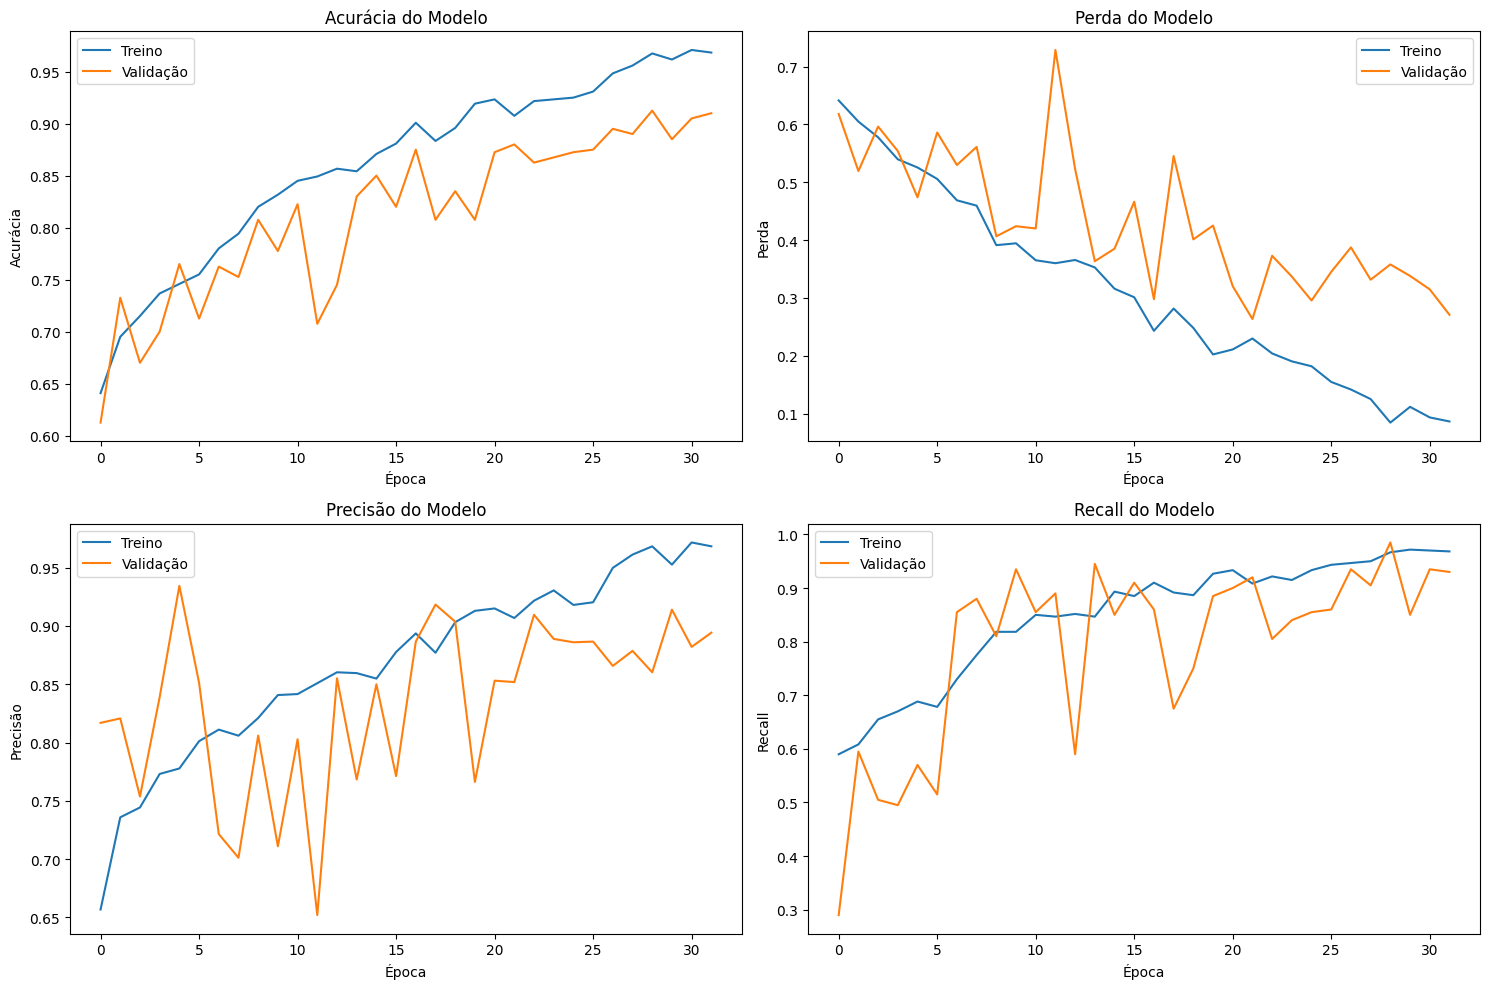


Avaliando modelo no conjunto de teste...
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 595ms/step

=== RELATÓRIO DE CLASSIFICAÇÃO ===
               precision    recall  f1-score   support

Não-Violência       0.91      0.90      0.90       200
    Violência       0.90      0.91      0.90       200

     accuracy                           0.90       400
    macro avg       0.90      0.90      0.90       400
 weighted avg       0.90      0.90      0.90       400



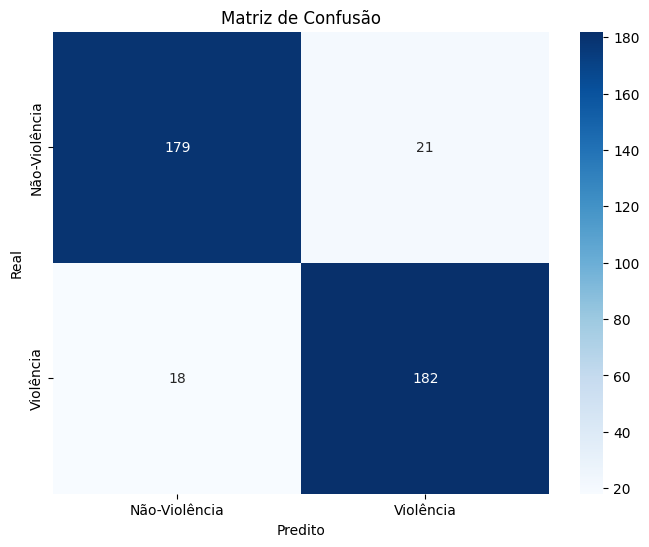


Modelo salvo como 'violence_detection_final_model.h5'

=== EXEMPLO DE PREDIÇÃO ===
Para usar o modelo treinado em um novo vídeo:
result, error = violence_detector.predict_video('caminho/para/video.mp4')
if error is None:
    print(f'Predição: {result["prediction"]} (Confiança: {result["confidence"]:.2f})')


In [ ]:
# class ViolenceDetectionModel:
#     def __init__(self, sequence_length=30, img_height=64, img_width=64, channels=3):
#         self.sequence_length = sequence_length
#         self.img_height = img_height
#         self.img_width = img_width
#         self.channels = channels
#         self.model = None
#         self.history = None
        
#     def extract_frames_from_video(self, video_path, max_frames=30):
#         """Extrai frames de um vídeo"""
#         frames = []
#         cap = cv2.VideoCapture(video_path)
        
#         if not cap.isOpened():
#             print(f"Erro ao abrir vídeo: {video_path}")
#             return None
            
#         total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
#         # Se o vídeo tem menos frames que o necessário, repete frames
#         if total_frames < max_frames:
#             frame_indices = np.linspace(0, total_frames-1, max_frames, dtype=int)
#         else:
#             frame_indices = np.linspace(0, total_frames-1, max_frames, dtype=int)
        
#         for frame_idx in frame_indices:
#             cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
#             ret, frame = cap.read()
            
#             if ret:
#                 # Redimensiona o frame
#                 frame = cv2.resize(frame, (self.img_width, self.img_height))
#                 # Converte BGR para RGB
#                 frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#                 # Normaliza para [0, 1]
#                 frame = frame.astype(np.float32) / 255.0
#                 frames.append(frame)
#             else:
#                 # Se não conseguir ler o frame, duplica o último
#                 if frames:
#                     frames.append(frames[-1])
#                 else:
#                     # Se não há frames, cria um frame preto
#                     frames.append(np.zeros((self.img_height, self.img_width, self.channels)))
        
#         cap.release()
#         return np.array(frames)
    
#     def load_dataset(self):
#         """Carrega o dataset de vídeos"""
#         sequences = []
#         labels = []
        
#         print("Carregando vídeos de violência...")
#         if os.path.exists(Violence_path):
#             violence_videos = [f for f in os.listdir(Violence_path) if f.endswith(('.mp4', '.avi', '.mov'))]
#             for video_file in tqdm(violence_videos):
#                 video_path = os.path.join(Violence_path, video_file)
#                 frames = self.extract_frames_from_video(video_path, self.sequence_length)
#                 if frames is not None and len(frames) == self.sequence_length:
#                     sequences.append(frames)
#                     labels.append(1)  # Violência = 1
        
#         print("Carregando vídeos de não-violência...")
#         if os.path.exists(NonViolence_path):
#             nonviolence_videos = [f for f in os.listdir(NonViolence_path) if f.endswith(('.mp4', '.avi', '.mov'))]
#             for video_file in tqdm(nonviolence_videos):
#                 video_path = os.path.join(NonViolence_path, video_file)
#                 frames = self.extract_frames_from_video(video_path, self.sequence_length)
#                 if frames is not None and len(frames) == self.sequence_length:
#                     sequences.append(frames)
#                     labels.append(0)  # Não-violência = 0
        
#         if not sequences:
#             raise ValueError("Nenhum vídeo foi carregado. Verifique os caminhos dos dados.")
        
#         sequences = np.array(sequences)
#         labels = np.array(labels)
        
#         print(f"Dataset carregado: {len(sequences)} sequências")
#         print(f"Forma dos dados: {sequences.shape}")
#         print(f"Distribuição das classes: Violência={np.sum(labels)}, Não-violência={len(labels)-np.sum(labels)}")
        
#         return sequences, labels
    
#     def create_cnn_feature_extractor(self):
#         """Cria a CNN para extração de características espaciais"""
#         model = Sequential([
#             # Primeiro bloco convolucional
#             Conv2D(32, (3, 3), activation='relu', 
#                    input_shape=(self.img_height, self.img_width, self.channels)),
#             BatchNormalization(),
#             MaxPooling2D((2, 2)),
            
#             # Segundo bloco convolucional
#             Conv2D(64, (3, 3), activation='relu'),
#             BatchNormalization(),
#             MaxPooling2D((2, 2)),
            
#             # Terceiro bloco convolucional
#             Conv2D(128, (3, 3), activation='relu'),
#             BatchNormalization(),
#             MaxPooling2D((2, 2)),
            
#             # Quarto bloco convolucional
#             Conv2D(256, (3, 3), activation='relu'),
#             BatchNormalization(),
            
#             # Pooling global e features
#             GlobalAveragePooling2D(),
#             Dense(512, activation='relu'),
#             Dropout(0.5)
#         ])
        
#         return model
    
#     def build_model(self):
#         """Constrói o modelo completo CNN + LSTM Bidirecional"""
#         # Input para sequência de frames
#         input_layer = Input(shape=(self.sequence_length, self.img_height, self.img_width, self.channels))
        
#         # CNN para extração de características (aplicada a cada frame)
#         cnn_model = self.create_cnn_feature_extractor()
        
#         # Aplicar CNN a cada frame da sequência
#         cnn_features = TimeDistributed(cnn_model)(input_layer)
        
#         # LSTM Bidirecional para modelagem temporal
#         lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(cnn_features)
#         lstm_out = Bidirectional(LSTM(64, dropout=0.3))(lstm_out)
        
#         # Camadas finais de classificação
#         dense_1 = Dense(128, activation='relu')(lstm_out)
#         dropout_1 = Dropout(0.5)(dense_1)
#         dense_2 = Dense(64, activation='relu')(dropout_1)
#         dropout_2 = Dropout(0.3)(dense_2)
        
#         # Saída final (classificação binária)
#         output = Dense(1, activation='sigmoid')(dropout_2)
        
#         # Criar modelo
#         model = Model(inputs=input_layer, outputs=output)
        
#         # Compilar modelo
#         model.compile(
#             optimizer=Adam(learning_rate=0.001),
#             loss='binary_crossentropy',
#             metrics=['accuracy', 'precision', 'recall']
#         )
        
#         self.model = model
#         return model
    
#     def train_model(self, X_train, y_train, X_val, y_val):
#         """Treina o modelo"""
#         if self.model is None:
#             self.build_model()
        
#         # Callbacks
#         callbacks = [
#             ModelCheckpoint(
#                 'best_violence_detection_model.h5',
#                 monitor='val_accuracy',
#                 save_best_only=True,
#                 mode='max',
#                 verbose=1
#             ),
#             EarlyStopping(
#                 monitor='val_loss',
#                 patience=10,
#                 restore_best_weights=True,
#                 verbose=1
#             ),
#             ReduceLROnPlateau(
#                 monitor='val_loss',
#                 factor=0.5,
#                 patience=5,
#                 min_lr=1e-6,
#                 verbose=1
#             )
#         ]
        
#         # Treinamento
#         print("Iniciando treinamento...")
#         self.history = self.model.fit(
#             X_train, y_train,
#             batch_size=BATCH_SIZE,
#             epochs=EPOCHS,
#             validation_data=(X_val, y_val),
#             callbacks=callbacks,
#             verbose=1
#         )
        
#         return self.history
    
#     def evaluate_model(self, X_test, y_test):
#         """Avalia o modelo"""
#         if self.model is None:
#             raise ValueError("Modelo não foi treinado ainda.")
        
#         # Predições
#         y_pred_prob = self.model.predict(X_test)
#         y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        
#         # Métricas
#         print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
#         print(classification_report(y_test, y_pred, target_names=['Não-Violência', 'Violência']))
        
#         # Matriz de confusão
#         cm = confusion_matrix(y_test, y_pred)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#                     xticklabels=['Não-Violência', 'Violência'],
#                     yticklabels=['Não-Violência', 'Violência'])
#         plt.title('Matriz de Confusão')
#         plt.xlabel('Predito')
#         plt.ylabel('Real')
#         plt.show()
        
#         return y_pred, y_pred_prob
    
#     def plot_training_history(self):
#         """Plota o histórico de treinamento"""
#         if self.history is None:
#             print("Nenhum histórico de treinamento disponível.")
#             return
        
#         fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
#         # Accuracy
#         axes[0, 0].plot(self.history.history['accuracy'], label='Treino')
#         axes[0, 0].plot(self.history.history['val_accuracy'], label='Validação')
#         axes[0, 0].set_title('Acurácia do Modelo')
#         axes[0, 0].set_xlabel('Época')
#         axes[0, 0].set_ylabel('Acurácia')
#         axes[0, 0].legend()
        
#         # Loss
#         axes[0, 1].plot(self.history.history['loss'], label='Treino')
#         axes[0, 1].plot(self.history.history['val_loss'], label='Validação')
#         axes[0, 1].set_title('Perda do Modelo')
#         axes[0, 1].set_xlabel('Época')
#         axes[0, 1].set_ylabel('Perda')
#         axes[0, 1].legend()
        
#         # Precision
#         axes[1, 0].plot(self.history.history['precision'], label='Treino')
#         axes[1, 0].plot(self.history.history['val_precision'], label='Validação')
#         axes[1, 0].set_title('Precisão do Modelo')
#         axes[1, 0].set_xlabel('Época')
#         axes[1, 0].set_ylabel('Precisão')
#         axes[1, 0].legend()
        
#         # Recall
#         axes[1, 1].plot(self.history.history['recall'], label='Treino')
#         axes[1, 1].plot(self.history.history['val_recall'], label='Validação')
#         axes[1, 1].set_title('Recall do Modelo')
#         axes[1, 1].set_xlabel('Época')
#         axes[1, 1].set_ylabel('Recall')
#         axes[1, 1].legend()
        
#         plt.tight_layout()
#         plt.show()
    
#     def predict_video(self, video_path, threshold=0.5):
#         """Prediz se um vídeo contém violência"""
#         frames = self.extract_frames_from_video(video_path, self.sequence_length)
        
#         if frames is None or len(frames) != self.sequence_length:
#             return None, "Erro ao processar vídeo"
        
#         # Adiciona dimensão do batch
#         frames = np.expand_dims(frames, axis=0)
        
#         # Predição
#         prediction_prob = self.model.predict(frames)[0][0]
#         prediction = prediction_prob > threshold
        
#         result = {
#             'probability': float(prediction_prob),
#             'prediction': 'Violência' if prediction else 'Não-Violência',
#             'confidence': float(max(prediction_prob, 1 - prediction_prob))
#         }
        
#         return result, None

# def main():
#     """Função principal para executar o sistema"""
#     # Criar instância do modelo
#     violence_detector = ViolenceDetectionModel(
#         sequence_length=SEQUENCE_LENGTH,
#         img_height=IMG_HEIGHT,
#         img_width=IMG_WIDTH,
#         channels=CHANNELS
#     )
    
#     try:
#         # Carregar dataset
#         print("Carregando dataset...")
#         sequences, labels = violence_detector.load_dataset()
        
#         # Dividir dados em treino, validação e teste
#         X_temp, X_test, y_temp, y_test = train_test_split(
#             sequences, labels, test_size=0.2, random_state=42, stratify=labels
#         )
#         X_train, X_val, y_train, y_val = train_test_split(
#             X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
#         )
        
#         print(f"Dados de treino: {X_train.shape[0]} amostras")
#         print(f"Dados de validação: {X_val.shape[0]} amostras")
#         print(f"Dados de teste: {X_test.shape[0]} amostras")
        
#         # Construir modelo
#         print("\nConstruindo modelo...")
#         model = violence_detector.build_model()
#         print(model.summary())
        
#         # Treinar modelo
#         print("\nIniciando treinamento...")
#         violence_detector.train_model(X_train, y_train, X_val, y_val)
        
#         # Plotar histórico de treinamento
#         violence_detector.plot_training_history()
        
#         # Avaliar modelo
#         print("\nAvaliando modelo no conjunto de teste...")
#         y_pred, y_pred_prob = violence_detector.evaluate_model(X_test, y_test)
        
#         # Salvar modelo final
#         violence_detector.model.save('violence_detection_final_model.h5')
#         print("\nModelo salvo como 'violence_detection_final_model.h5'")
        
#         # Exemplo de predição em um novo vídeo
#         print("\n=== EXEMPLO DE PREDIÇÃO ===")
#         print("Para usar o modelo treinado em um novo vídeo:")
#         print("result, error = violence_detector.predict_video('caminho/para/video.mp4')")
#         print("if error is None:")
#         print("    print(f'Predição: {result[\"prediction\"]} (Confiança: {result[\"confidence\"]:.2f})')")
        
#     except Exception as e:
#         print(f"Erro durante a execução: {str(e)}")
#         print("Verifique se os caminhos dos dados estão corretos e contêm vídeos válidos.")

# if __name__ == "__main__":
#     main()